# EDA and intial testing of LSTM on QQQ v SPX strategy

In [1]:
%matplotlib inline

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import copy

from sklearn.preprocessing import MinMaxScaler, Normalizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


Using TensorFlow backend.


In [2]:
tickers = [
    '^GSPC',  # S&P 500
    '^IXIC',  # NASDAQ
#     'GSPX.L', 
#     'EQGB.L',  
]

yday = datetime.now() - timedelta(1)
start_date = '1990-01-01'
end_date = yday.strftime('%Y-%m-%d')

panel_data = data.DataReader(tickers , 'yahoo', start_date, end_date)
close_data = panel_data.loc[:, ('Close', slice(None))]
close_data.columns = close_data.columns.droplevel()

/Users/finlayoneill/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


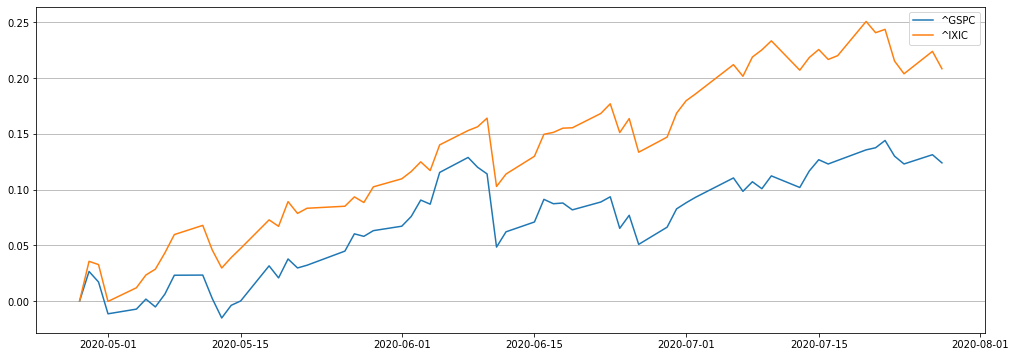

In [3]:
# titles = close_data.columns
chart_data = close_data.iloc[-64:, :].pct_change()
chart_data.iloc[0, :] = 0
chart_data = np.cumprod(1 + chart_data) - 1

plt.figure(figsize = (17,6))
plt.plot(chart_data[tickers])
plt.grid(axis = 'y')
plt.legend(tickers, loc = 'best');

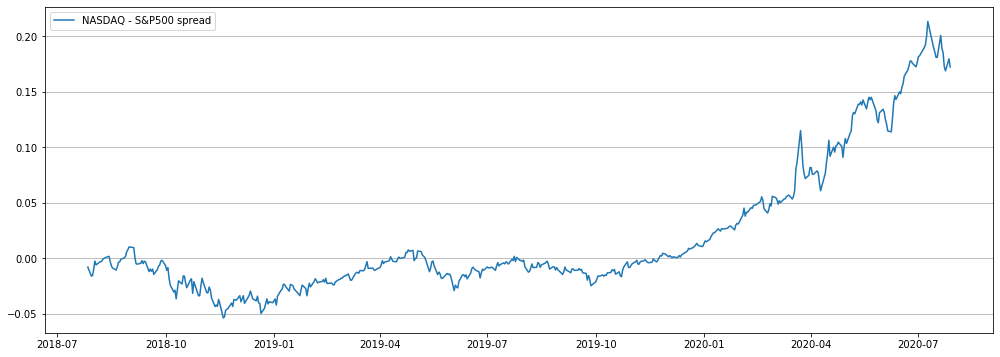

In [4]:
period = 505
nasdaq_v_spx = close_data.iloc[-period:, 1].pct_change() - close_data.iloc[-period:, 0].pct_change()
nasdaq_v_spx = np.cumprod(1 + nasdaq_v_spx) - 1

plt.figure(figsize = (17,6))
plt.plot(nasdaq_v_spx, label = 'NASDAQ - S&P500 spread')
plt.grid(axis = 'y')
plt.legend(loc = 'best');

___
# LSTM

- Use LSTM model
- Inputs: weekly spread between QQQ and SPX over different time windows
- Target: weekly spread

In [5]:
pct_nasdaq_v_spx = (close_data.iloc[:, 1].pct_change() - close_data.iloc[:, 0].pct_change()).fillna(0)
cum_nasdaq_v_spx = np.cumprod(1 + pct_nasdaq_v_spx) - 1

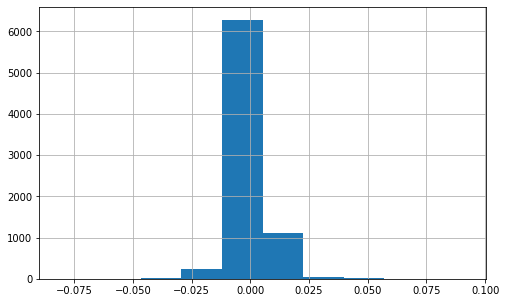

In [6]:
pct_nasdaq_v_spx.hist(figsize = (8, 5));

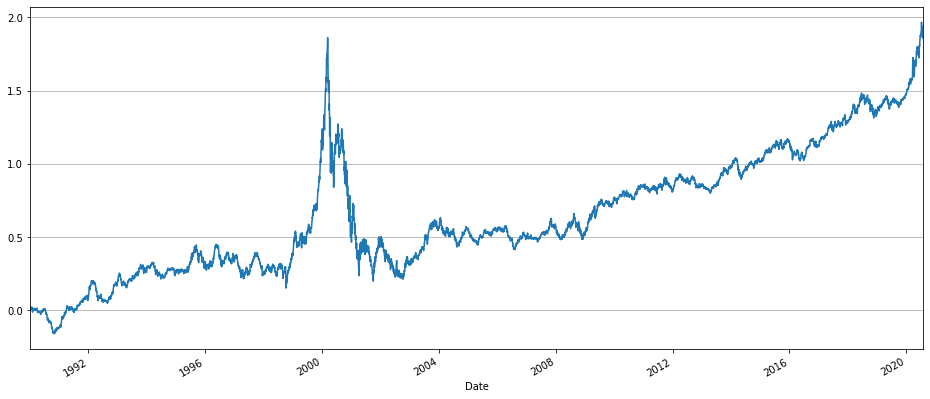

In [7]:
cum_nasdaq_v_spx.plot(figsize = (16, 7))
plt.grid(axis = 'y');

In [8]:
wkly_nsdq_v_spx = (cum_nasdaq_v_spx + 1).resample('W-FRI').last()
pct_wkly_nsdq_v_spx = wkly_nsdq_v_spx.pct_change().fillna(0) ## for now just doing friday close to friday close

Max weekly return: 0.11306082914061255
Min weekly return: -0.16150905753141065


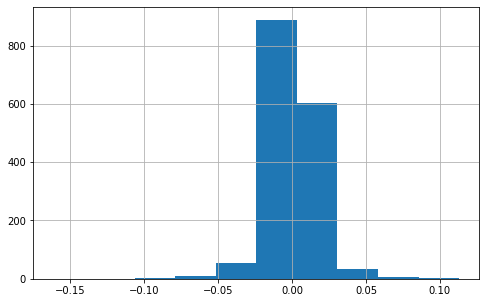

In [9]:
pct_wkly_nsdq_v_spx.hist(figsize = (8, 5));
print('Max weekly return:', np.max(pct_wkly_nsdq_v_spx))
print('Min weekly return:', np.min(pct_wkly_nsdq_v_spx))

## Train Test Split

In [10]:
# pct_wkly_nsdq_v_spx.shape[0]

In [11]:
# train_len = pct_wkly_nsdq_v_spx.shape[0] - 60 
train_len = wkly_nsdq_v_spx.shape[0] - (52 * 5)

# train = pct_wkly_nsdq_v_spx.iloc[:train_len].values.reshape(-1, 1)
# test = pct_wkly_nsdq_v_spx.iloc[train_len:].values.reshape(-1, 1)
train = wkly_nsdq_v_spx.iloc[:train_len].values.reshape(-1, 1)
test = wkly_nsdq_v_spx.iloc[train_len:].values.reshape(-1, 1)


train.shape, test.shape

((1336, 1), (260, 1))

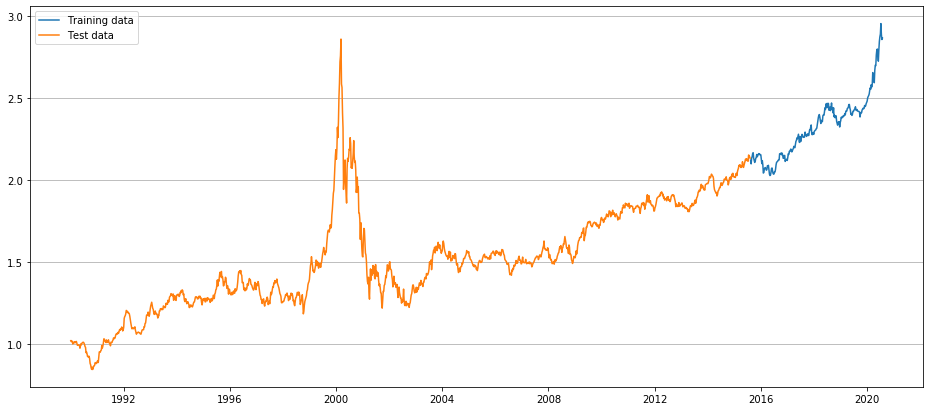

In [12]:
train_chart_data = copy.deepcopy(wkly_nsdq_v_spx)
test_chart_data = copy.deepcopy(wkly_nsdq_v_spx)

train_chart_data.iloc[:train_len] = np.nan
test_chart_data.iloc[train_len:] = np.nan

plt.figure(figsize = (16, 7))
plt.plot(train_chart_data, label = 'Training data')
plt.plot(test_chart_data, label = 'Test data')
plt.legend()
plt.grid(axis = 'y');

Is it important that the test data set has some visual similarity to the training data set? The first testing done used the most recent 60 weeks as the test set. This period saw the spread between QQQ and SPX increase much faster than the general trend. The second run had a test set that was about 3 times larger.

In [13]:
# plt.figure(figsize = (16, 14))
# plt.subplot(211)
# plt.plot(wkly_nsdq_v_spx.iloc[:train_len])
# plt.grid(axis = 'y')
# plt.subplot(212)
# plt.plot(wkly_nsdq_v_spx.iloc[train_len:])
# plt.grid(axis = 'y');

## Scale Data

In [14]:
scaler = MinMaxScaler()

scaler.fit(train) # ONLY FIT TO TRAINING DATA
scaled_train = scaler.transform(train) # each column ranges from 0 to 1
scaled_test = scaler.transform(test)

scaled_train.max(), scaled_test.max()

(1.0, 1.046837434328555)

## Time Series Generator
- `n_inputs` = the rolling window length (number of weeks)
- `n_cols` = the number of columns being trained (for univariate time-series, this is 1)

In [15]:
n_input = 52 # a smaller number of inputs than the test set size will lead to predictions based on predicted values
n_cols = scaled_train.shape[1]

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [16]:
# What does the first batch look like?
X, y = generator[0]

print(f'Given the Array: \n{X}')
print(f'Predict this y: \n {y}')

Given the Array: 
[[[0.08725221]
  [0.08425994]
  [0.08673244]
  [0.08391931]
  [0.07720955]
  [0.08082631]
  [0.08234924]
  [0.08416985]
  [0.08036153]
  [0.08340131]
  [0.08366648]
  [0.0849889 ]
  [0.07885197]
  [0.07337806]
  [0.07336946]
  [0.07470871]
  [0.07449419]
  [0.07312472]
  [0.06445883]
  [0.07201058]
  [0.07798969]
  [0.07517125]
  [0.07991156]
  [0.08123662]
  [0.08259065]
  [0.08219255]
  [0.07961842]
  [0.07580115]
  [0.06953624]
  [0.06694189]
  [0.0508968 ]
  [0.05318566]
  [0.04711904]
  [0.03905026]
  [0.04003644]
  [0.03785053]
  [0.03992787]
  [0.03297801]
  [0.01829099]
  [0.01427785]
  [0.00521124]
  [0.00035672]
  [0.00715935]
  [0.        ]
  [0.00415199]
  [0.01055344]
  [0.01095327]
  [0.01353741]
  [0.02092639]
  [0.01894753]
  [0.01806089]
  [0.01922742]]]
Predict this y: 
 [[0.02486927]]


## Create the model

In [17]:
# # define model
# model = Sequential()

# model.add(LSTM(300, activation = 'relu', input_shape = (n_input, n_cols)))
# model.add(Dense(1))
# model.compile(optimizer = 'adam', loss = 'mse')
# model.summary()

In [18]:
# define model
model = Sequential()

model.add(LSTM(300, activation = 'relu', return_sequences = True, input_shape = (n_input, n_cols)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(300, activation = 'relu', return_sequences = True))
model.add(Dropout(rate = 0.2))

# model.add(LSTM(100, activation = 'relu', return_sequences = True))
# model.add(Dropout(rate = 0.2))

model.add(LSTM(300, activation = 'relu', return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 52, 300)           362400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 52, 300)           721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 52, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [19]:
early_stopping = EarlyStopping(monitor = 'loss', patience = 1)
model.fit_generator(generator, epochs = 25, callbacks = [early_stopping])

Epoch 1/25
1284/1284 [==============================] - 97s 76ms/step - loss: 0.0061
Epoch 2/25
1284/1284 [==============================] - 96s 75ms/step - loss: 0.0027
Epoch 3/25
1284/1284 [==============================] - 99s 77ms/step - loss: 0.0021
Epoch 4/25
1284/1284 [==============================] - 99s 77ms/step - loss: 0.0018
Epoch 5/25
1284/1284 [==============================] - 100s 78ms/step - loss: 0.0017
Epoch 6/25
1284/1284 [==============================] - 93s 73ms/step - loss: 0.0016
Epoch 7/25
1284/1284 [==============================] - 98s 76ms/step - loss: 0.0015
Epoch 8/25
1284/1284 [==============================] - 100s 78ms/step - loss: 0.0015
Epoch 9/25
1284/1284 [==============================] - 99s 77ms/step - loss: 0.0013
Epoch 10/25
1284/1284 [==============================] - 95s 74ms/step - loss: 0.0013


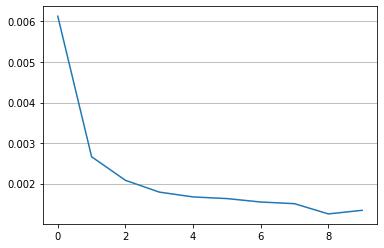

In [20]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.grid(axis = 'y');


## Evaluate on Test Data

In [21]:
scaled_train.shape

(1336, 1)

In [22]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_cols))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :],[[current_pred]], axis = 1)

### Inverse Transformations and Compare

In [23]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions.shape, test.shape

((260, 1), (260, 1))

(260,)


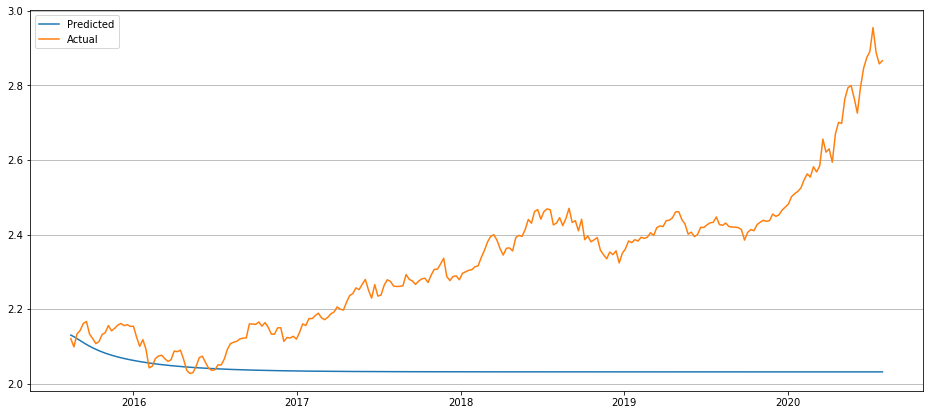

In [24]:
dates = wkly_nsdq_v_spx.index[-test.shape[0]:]
print(dates.shape)

plt.figure(figsize = (16, 7))
plt.plot(dates, true_predictions, label = 'Predicted')
plt.plot(dates, test, label = 'Actual')
plt.grid(axis = 'y')
plt.legend();

In [ ]:
# Room to improve the model...